# シェアバイクの需要予測



## 参考
https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

In [1]:
from datetime import datetime

import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
import matplotlib.pyplot as plt
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [11]:
# データの読み込み
dailyData = pd.read_csv('data/train.csv')

## データの統計量

In [12]:
print('shape: ', dailyData.shape)

shape:  (10886, 12)


In [13]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [14]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## 特徴エンジニアリング
- 'datetime'カラムから、'date', 'hour', 'weekDay', 'month'カラムを作成
- 'season', 'holiday', 'workingday', 'weather'をintからcategoryに変換
- 最後に'datetime'カラムを削除

In [15]:
# 新しいカラムの作成
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

# 型変換
categoryVariableList = ['hour', 'weekday', 'month', 'season', 'weather', 'holiday', 'workingday']
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype('category')

# 不要なカラムの削除
dailyData = dailyData.drop(['datetime'], axis=1)

In [16]:
dailyData.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January


## 可視化

In [19]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

TypeError: data type "" not understood

In [18]:
dailyData.dtypes.value_counts()

int64       4
float64     3
category    2
category    1
object      1
category    1
category    1
category    1
category    1
dtype: int64

## 欠損値処理

### 歪度（skewness）

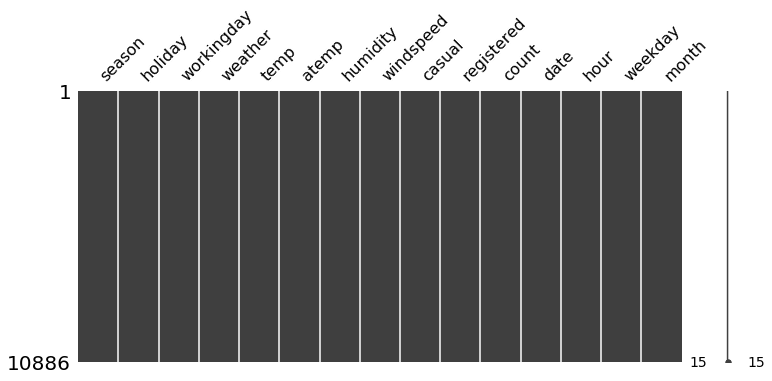

In [20]:
msno.matrix(dailyData, figsize=(12, 5))

## 外れ値